In [95]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pytesseract
from shapely import LineString, Point, Polygon, box

# Importar datos desde csv

In [2]:
data_segmentos = '../01_ingest_labeled_data/output_csv/data_segments.csv'
data_imagenes = '../01_ingest_labeled_data/output_csv/data_images.csv'
df_segmentos = pd.read_csv(data_segmentos).drop(columns=['Unnamed: 0'])
df_imagenes = pd.read_csv(data_imagenes).drop(columns=['Unnamed: 0'])

In [3]:
df_segmentos.head()

,file,x_1,y_1,x_2,y_2,label,content
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender..."


In [4]:
df_imagenes.head()

,file,bitmap,height,width
0,Crónica 1983-12-14 General Weher Justifico tod...,[[[255 255 255]\n [255 255 255]\n [255 255 2...,971.0,1672.0
1,La Razon 1986-12-05 Los senadores de la Renova...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...,1009.0,1202.0
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,[[[255 255 255]\n [255 255 255]\n [255 255 2...,252.0,945.0


In [5]:
articulo = df_imagenes.iloc[2]
articulo

file      La Gaceta de hoy 1986-12-24 Arosa descartó un ...
bitmap    [[[255 255 255]\n  [255 255 255]\n  [255 255 2...
height                                                252.0
width                                                 945.0
Name: 2, dtype: object

In [6]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']]
segmentos_articulo

,file,x_1,y_1,x_2,y_2,label,content
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender..."
5,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,162,936,227,Cuerpo,"El ministro del Interior, Antonio Tróccoli, so..."


# Obtener tokens

In [110]:
path_images = '../01_ingest_labeled_data/iaxidentidad_tif'

In [111]:
mi_cfg = r"-l spa --psm 3 --oem 3"

In [112]:
#cajas = pytesseract.image_to_boxes(imagen_cv, config=mi_cfg)

In [113]:
df_tokens = pytesseract.image_to_data(path_images + '/' + articulo['file'], config=mi_cfg, output_type=pytesseract.Output.DATAFRAME)

In [114]:
df_tokens

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,945,252,-1.000000,NaN
1,2,1,1,0,0,0,15,21,843,57,-1.000000,NaN
2,3,1,1,1,0,0,15,21,843,57,-1.000000,NaN
3,4,1,1,1,1,0,15,21,843,57,-1.000000,NaN
4,5,1,1,1,1,1,15,28,156,50,96.395561,AROSA
...,...,...,...,...,...,...,...,...,...,...,...,...
304,4,1,8,1,2,0,642,206,286,19,-1.000000,NaN
305,5,1,8,1,2,1,642,216,14,6,38.082321,Sin
306,5,1,8,1,2,2,660,214,63,11,80.541786,sospechas”.
307,5,1,8,1,2,3,808,207,5,7,0.000000,u


## Generar poligonos de bounding boxes a partir de coordenadas

In [96]:
def get_polygons_from_xywh(row):
    p1 = Point(row['left'], row['top'])
    p2 = Point(row['left']+row['width'], row['top'])
    p3 = Point(row['left']+row['width'], row['top']+row['height'])
    p4 = Point(row['left'], row['top']+row['height'])
    p_list = [p1, p2, p3, p4]
    row['poligono'] = box([p.x, p.y] for p in p_list)
    return row

def get_polygons_from_xyxy(row):
    p1 = Point(row['x_1'], row['y_1'])
    p2 = Point(row['x_2'], row['y_1'])
    p3 = Point(row['x_2'], row['y_2'])
    p4 = Point(row['x_1'], row['y_2'])
    p_list = [p1, p2, p3, p4]
    row['poligono'] = box([p.x, p.y] for p in p_list)
    return row

In [115]:
df_tokens['poligono'] = df_tokens.apply(lambda row: box(row.left, row.top, row.left + row.width, row.top + row.height), axis=1)
df_tokens

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,poligono
0,1,1,0,0,0,0,0,0,945,252,-1.000000,NaN,"POLYGON ((945 0, 945 252, 0 252, 0 0, 945 0))"
1,2,1,1,0,0,0,15,21,843,57,-1.000000,NaN,"POLYGON ((858 21, 858 78, 15 78, 15 21, 858 21))"
2,3,1,1,1,0,0,15,21,843,57,-1.000000,NaN,"POLYGON ((858 21, 858 78, 15 78, 15 21, 858 21))"
3,4,1,1,1,1,0,15,21,843,57,-1.000000,NaN,"POLYGON ((858 21, 858 78, 15 78, 15 21, 858 21))"
4,5,1,1,1,1,1,15,28,156,50,96.395561,AROSA,"POLYGON ((171 28, 171 78, 15 78, 15 28, 171 28))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,4,1,8,1,2,0,642,206,286,19,-1.000000,NaN,"POLYGON ((928 206, 928 225, 642 225, 642 206, ..."
305,5,1,8,1,2,1,642,216,14,6,38.082321,Sin,"POLYGON ((656 216, 656 222, 642 222, 642 216, ..."
306,5,1,8,1,2,2,660,214,63,11,80.541786,sospechas”.,"POLYGON ((723 214, 723 225, 660 225, 660 214, ..."
307,5,1,8,1,2,3,808,207,5,7,0.000000,u,"POLYGON ((813 207, 813 214, 808 214, 808 207, ..."


In [105]:
df_segmentos['poligono'] = df_segmentos.apply(lambda row: box(row.x_1, row.y_1, row.x_2, row.y_2), axis=1)
df_segmentos

,file,x_1,y_1,x_2,y_2,label,content,poligono
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR,"POLYGON ((863 19, 863 78, 12 78, 12 19, 863 19))"
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI,"POLYGON ((761 144, 761 159, 642 159, 642 144, ..."
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...,"POLYGON ((309 92, 309 229, 14 229, 14 92, 309 ..."
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ...","POLYGON ((623 90, 623 228, 323 228, 323 90, 62..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender...","POLYGON ((932 90, 932 142, 641 142, 641 90, 93..."
...,...,...,...,...,...,...,...,...
182,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,95,417,419,894,Cuerpo,El doctor Julio Desiderio\nBurlando a cargo de...,"POLYGON ((419 417, 419 894, 95 894, 95 417, 41..."
183,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,446,417,764,892,Cuerpo,privación ilegítima de libertad\ny violación d...,"POLYGON ((764 417, 764 892, 446 892, 446 417, ..."
184,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,796,417,1122,892,Cuerpo,"Plata, y no lo habría denunciado\n.\nEl magist...","POLYGON ((1122 417, 1122 892, 796 892, 796 417..."
185,Tiempo Argentino 1986-01-10 Querella del ex......,71,9,640,146,Título,"Querella del ex oficial\nHours por ""injurias""","POLYGON ((640 9, 640 146, 71 146, 71 9, 640 9))"


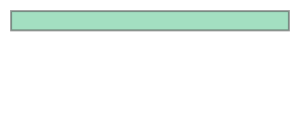

In [116]:
df_segmentos['poligono'][0]

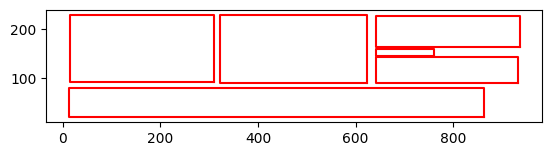

In [121]:
# Obtener las coordenadas de los vértices de cada objeto
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
for r in segmentos_articulo['poligono']:
    r_coords = list(r.exterior.coords)

    ax.plot(*zip(*r_coords), color='r')
    # Dibujar los objetos en un gráfico

plt.show()

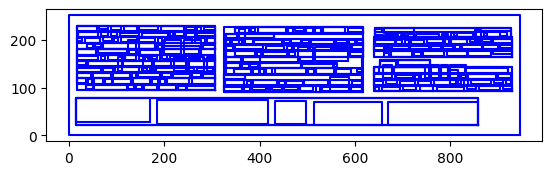

In [123]:
# Obtener las coordenadas de los vértices de cada objeto
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
for r in df_tokens['poligono']:
    r_coords = list(r.exterior.coords)

    ax.plot(*zip(*r_coords), color='b')
    # Dibujar los objetos en un gráfico
plt.show()

## Obtener etiqueta de tokens a partir de etiquetado manual

In [247]:
def get_label_token(poligono_token, segmentos_articulo):
    #segmentos_articulo = df_segmentos[df_segmentos['file']==file][['poligono', 'label']]
    #print(segmentos_articulo.shape)
    etiqueta = np.nan
    label_candidates = {'etiqueta': np.nan, 'perc': np.nan}

    for _, segmento in segmentos_articulo.iterrows():
        #print('Poligono token: ')
        #display(poligono_token)
        #print('Poligono segmento: ')
        #display(_, segmento['poligono'])
        if poligono_token.intersects(segmento['poligono']):
            perc = (poligono_token.intersection(segmento['poligono']).area / poligono_token.union(segmento['poligono']).area)*100
            if (label_candidates['perc'] != np.nan) or (label_candidates['perc'] < perc):
                label_candidates = {'etiqueta': segmento['label'], 'perc': perc}
    
    return label_candidates['etiqueta']

In [248]:
label_candidates

NameError: name 'label_candidates' is not defined

In [249]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']][['poligono', 'label']]
df_tokens['poligono'].apply(lambda x: get_label_token(x, segmentos_articulo)).value_counts()

Cuerpo       296
Título         8
Destacado      5
Name: poligono, dtype: int64

In [124]:
segmentos_articulo

,poligono,label
0,"POLYGON ((863 19, 863 78, 12 78, 12 19, 863 19))",Título
1,"POLYGON ((761 144, 761 159, 642 159, 642 144, ...",Destacado
2,"POLYGON ((309 92, 309 229, 14 229, 14 92, 309 ...",Cuerpo
3,"POLYGON ((623 90, 623 228, 323 228, 323 90, 62...",Cuerpo
4,"POLYGON ((932 90, 932 142, 641 142, 641 90, 93...",Cuerpo
5,"POLYGON ((936 162, 936 227, 642 227, 642 162, ...",Cuerpo


In [125]:
df_tokens['poligono']

0          POLYGON ((945 0, 945 252, 0 252, 0 0, 945 0))
1       POLYGON ((858 21, 858 78, 15 78, 15 21, 858 21))
2       POLYGON ((858 21, 858 78, 15 78, 15 21, 858 21))
3       POLYGON ((858 21, 858 78, 15 78, 15 21, 858 21))
4       POLYGON ((171 28, 171 78, 15 78, 15 28, 171 28))
                             ...                        
304    POLYGON ((928 206, 928 225, 642 225, 642 206, ...
305    POLYGON ((656 216, 656 222, 642 222, 642 216, ...
306    POLYGON ((723 214, 723 225, 660 225, 660 214, ...
307    POLYGON ((813 207, 813 214, 808 214, 808 207, ...
308    POLYGON ((928 206, 928 218, 854 218, 854 206, ...
Name: poligono, Length: 309, dtype: object

In [24]:
get_label_token(articulo['file'], df_tokens['poligono'][0], df_segmentos)

TypeError: string indices must be integers

In [ ]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']]

In [34]:
poli_1 = df_segmentos['poligono'][0]

In [36]:
poli_2 = df_tokens['poligono'][0]

In [59]:
poli_1.overlaps(poli_2)

False

In [76]:
for segmento in segmentos_articulo.iterrows():
    print(segmento[1]['label'])

Título
Destacado
Cuerpo
Cuerpo
Cuerpo
Cuerpo
